In [1]:
from osirisl1services.readlevel1 import open_level1_ir
from osirisl1services.services import Level1Services
import sys
sys.path.append('..')
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from scipy.interpolate import interp1d
from netCDF4 import num2date
units = 'days since 1858-11-17 00:00:00.000'

In [50]:
channel = 2
orbit = 22132
ir = open_level1_ir(orbit, channel)
num2date(ir.mjd[0],units)

datetime.datetime(2005, 3, 16, 19, 41, 14, 450746)

In [51]:
tan_alt = ir.l1.altitude
tan_lat = ir.l1.latitude
tan_lon = ir.l1.longitude
sc_look = ir.l1.look_ecef
sc_pos = ir.l1.position_ecef
l1 = ir.data

#====drop all dates which have nan in l1
#l1 = l1.dropna('mjd')
sc_look = sc_look.sel(mjd=l1.mjd)
sc_pos = sc_pos.sel(mjd=l1.mjd)
tan_lat = tan_lat.sel(mjd=l1.mjd)
tan_lon = tan_lon.sel(mjd=l1.mjd)
tan_alt = tan_alt.sel(mjd=l1.mjd)
mjd = l1.mjd.data
pixel = l1.pixel.data

In [52]:
im_lst = np.arange(850,1120,1)
pix_lst = np.arange(22, 128)

label_interval = 50

len(im_lst)

270

/home/anqil/anaconda3/lib/python3.6/site-packages/scipy/interpolate/interpolate.py:688: RuntimeWarning: invalid value encountered in less
  below_bounds = x_new < self.x[0]
/home/anqil/anaconda3/lib/python3.6/site-packages/scipy/interpolate/interpolate.py:689: RuntimeWarning: invalid value encountered in greater
  above_bounds = x_new > self.x[-1]
/home/anqil/anaconda3/lib/python3.6/site-packages/matplotlib/colors.py:1012: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


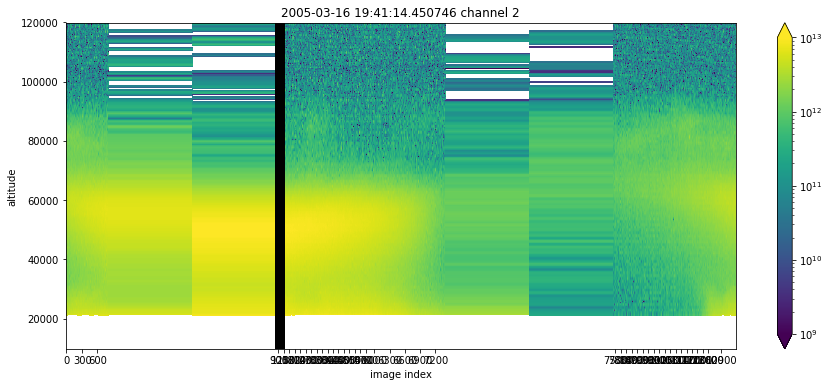

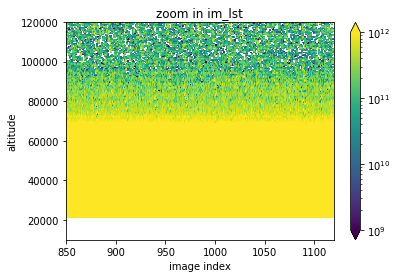

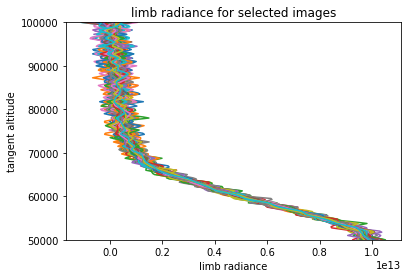

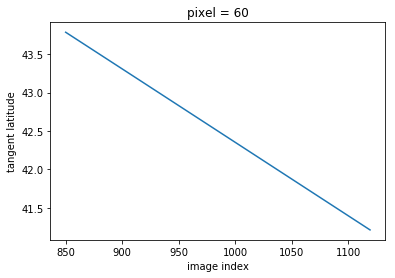

In [53]:
#%% interpolation 
alts_interp = np.arange(10e3, 120e3, .25e3)
data_interp = []


for (data, alt) in zip(l1, tan_alt):
    f = interp1d(alt, data, bounds_error=False)
    data_interp.append(f(alts_interp))
data_interp = xr.DataArray(data_interp, coords=[l1.mjd, alts_interp],
                           dims=['mjd', 'altitude'])

#%%plotting
plt.figure(figsize=(15,6))
data_interp.plot(x='mjd', y='altitude',
                 norm=LogNorm(), vmin=1e9, vmax=1e13)
plt.title(str(num2date(ir.mjd[0],units))+' channel '+str(channel))
plt.axvline(x=mjd[im_lst[0]], color='k', linewidth=5)
plt.axvline(x=mjd[im_lst[-1]], color='k', linewidth=5)
ax = plt.gca()
ax.set_xticks(mjd[np.arange(0,len(mjd),300, dtype=int)])
ax.set_xticklabels(np.arange(0,len(mjd),300))
ax.set(xlabel='image index')
plt.show()


plt.figure()
data_interp.isel(mjd=im_lst).plot(x='mjd', y='altitude', 
                 norm=LogNorm(), 
                 vmin=1e9, vmax=1e12)#, 
                 #size=5, aspect=3)
ax = plt.gca()
ax.set(title='zoom in im_lst',
      xlabel='image index')
ax.set_xticks(mjd[im_lst[::label_interval]])
ax.set_xticklabels(im_lst[::label_interval])
plt.show()

plt.figure()
plt.plot(data_interp.isel(mjd=im_lst).T, alts_interp)
ax = plt.gca()
ax.set(ylabel='tangent altitude', 
       xlabel='limb radiance',
       title='limb radiance for selected images',
       ylim=[50e3,100e3])

plt.figure()
tan_lat.isel(mjd=im_lst, pixel=60).plot()
ax = plt.gca()
ax.set_xticks(mjd[im_lst[::label_interval]])
ax.set_xticklabels(im_lst[::label_interval])
ax.set(xlabel='image index',
      ylabel='tangent latitude')
plt.show()
